In [1]:
import sys
sys.path.append('..')

from common.utility import show_implementation

# Fuzzy Numbers
## Extension Principle
Suppose that we have a fuzzy set $\mu_A$ with some membership function using the variable $x$, and a relationship between the variable $x$ and $y$.
How can we create a fuzzy set $\mu_B$ with respect to the variable $y$?

For example, when we have the following fuzzy set for *around-3*, with the following membership function. 
$$0.8/2 + 1/3 + 0.8/4$$

Can we, for instance, generate a similar fuzzy set for *around-6*?

It is intuitive to think that *around-6* would be 
$$0.8/5 + 1/6 + 0.8/7$$

To formalise this, in this case, our relationship $f(x)$ is $f(x) = x+3$.

Notice that the membership grade is simply $$\mu_B(f(x)) = \mu_A(x)$$

However, the relationship function may not be bijective.
Consider, for example, the following fuzzy set for *around-0*.
$$
0.3/\text{ -}2 + 0.8/\text{ -}1 + 1/0 + 0.7/1 + 0.5/2
$$
And suppose we wish to find *positive-around-0*, where our relationship function is $f(x) = |x|$.

Notice that both $-2$ and $2$ maps to the same value of $2$ in $B$, similarly for $-1$ and $1$.
If we were working with crisp sets, we would simply include $2$ in $B$ since both of them indicate the presence of $2$ in the set.
To perform a similar operation in fuzzy sets, we take the maximum of all possible membership grade associated with the value, thus $$\mu_B(y) = \max_{x | f(x) = y} \mu_A(x)$$

Therefore, the fuzzy set of *positive-around-0* is 
$$
1/0 + 0.8/1 + 0.5/2
$$

Thus, the implementation is simply just as below

In [2]:
from module.fuzzy_set import DiscreteFuzzySet
show_implementation(DiscreteFuzzySet, 'Section 4')

class DiscreteFuzzySet(FuzzySet):

    """Section 4: Transformation"""

    def transform(self, func):
        new_mapping = defaultdict(float)
        
        for value, grade in zip(self.values, self.grades):
            value = func(value)
            new_mapping[value] = max(new_mapping[value], grade)
    
        return DiscreteFuzzySet([(b,a) for a,b in sorted(new_mapping.items())])

    def center(self):
        return sum([grade*value for value,grade in self.membership_dict.items()])/sum(self.grades)


In [3]:
A = DiscreteFuzzySet.from_string('0.3/-2 + 0.8/-1 + 1/0+ 0.7/1 + 0.5/2')
A.transform(lambda x: abs(x))

1/0 + 0.8/1 + 0.5/2

## Fuzzy Number
A fuzzy set is a **fuzzy number** if 
* it is normal
* all $\alpha$-cut is a closed interval
* it has a bounded support

Fuzzy numbers is a model for quantitative approximation such as around 1.5 meters tall, around 50kg, etc.

## Arithmetic
We can apply the extension principle to define fuzzy number arithmetic, where
$$
(A*B)(z) = \max_{z = x*y}\min(A(x), B(y))
$$
wherem $*$ is any of the 4 basic arithmetic operators $(+, -, \times, /)$

For example, given *around-3* as below,
$$0.8/2 + 1/3 + 0.8/4$$

We can define *around-6* = *around-3* + *around-3*,
$$
0.8/4 + 0.8/5 + 1/6 + 0.8/7 + 0.8/8
$$
Notice that this is slightly different from the one we obtain previously, because we are looking at this as the result of adding two fuzzy numbers, while the previous is mapping a fuzzy number to a new domain.
Also notice that this correspond to our intuitive understanding, because the highest membership grade is around the value 6.

**Note**: If we have variables $A$ and $B$, both of whose membership grades are
$$0.8/2 + 1/3 + 0.8/4$$
It is important to know that $A+B \neq A+A$
This is because $A+B$ has two degree of freedom since there is two variables, while $A+A$ only has one degree of freedom.
Thus, the membership grade of $A+B$ is 
$$
0.8/4 + 0.8/5 + 1/6 + 0.8/7 + 0.8/8
$$
while the membership grade of $A+A$ is
$$
0.8/4 + 1/6 + 0.8/8
$$

Hence, the implementation is as per below.

In [4]:
from module.fuzzy_number import DiscreteFuzzyNumber
show_implementation(DiscreteFuzzyNumber)

class DiscreteFuzzyNumber(DiscreteFuzzySet):

    def _combine(self, other, func):
        new_mapping = {}
        for value, grade in zip(self.values, self.grades):
            for other_value, other_grade in zip(other.values, other.grades):
                new_value = func(value, other_value)
                new_grade = min(grade, other_grade)
                if new_value not in new_mapping:
                    new_mapping[new_value] = new_grade
                else:
                    new_mapping[new_value] = max(new_mapping[new_value], new_grade)

        return DiscreteFuzzyNumber([(b,a) for a,b in sorted(new_mapping.items())])
      
    def __add__(self, other):
        if self == other:
            return self.transform(lambda x: x + x)
        return self._combine(other, lambda a,b: a+b)
    def __sub__(self, other):
        if self == other:
            return self.transform(lambda x: x - x)
        return self._combine(other, lambda a,b: a-b)
    def __mul__(self, other):


In [5]:
A = DiscreteFuzzyNumber.from_string('0.8/2+1/3+0.8/4')
B = DiscreteFuzzyNumber.from_string('0.8/2+1/3+0.8/4')

print('A+B:', A+B)
print('A+A:', A+A)
print('A-B:', A-B)
print('A*B:', A*B)
print('A/B:', A/B)

A+B: 0.8/4 + 0.8/5 + 1/6 + 0.8/7 + 0.8/8
A+A: 0.8/4 + 1/6 + 0.8/8
A-B: 0.8/-2 + 0.8/-1 + 1/0 + 0.8/1 + 0.8/2
A*B: 0.8/4 + 0.8/6 + 0.8/8 + 1/9 + 0.8/12 + 0.8/16
A/B: 0.8/0.5 + 0.8/0.667 + 0.8/0.75 + 1/1 + 0.8/1.33 + 0.8/1.5 + 0.8/2


We have discussed the previous with respect to discrete fuzzy number.
For continuous fuzzy numbers, we can discretize the function and apply the previous principle.
However, this will generate a wrong membership function due to the discretization.

To combat this issue, we can apply the <a href='./fuzzy-operations.ipynb#decomposition-theorem'>decomposition theorem</a> to obtain crisp sets, and apply the extension principle on these sets instead. After obtaining the resultant crisps sets, the union of the sets is our resultant membership function.

## Arithmetic on Intervals
### Addition
$[a,b] + [c,d] = [a+c, b+d]$
### Subtraction
$[a,b] - [c,d] = [a-c, b-c]$
### Multiplication
$[a,b] \times [c,d] = [\min(ac, ad, bc, bd), \max(ac, ad, bc, bd)]$
### Division

**Only applicable if $0 \not \in [c,d]$**

$[a,b] / [c,d] = [\min(a/c, a/d, b/c, b/d), \max(a/c, a/d, b/c, b/d)]$

For multiplication and division, we need to consider all 4 numbers because the interval may contain negative numbers, which means the maximum and minimum will not always be dependent on only the upper or lower bound.

## Worked Example
Suppose that we have the following fuzzy numbers for *around-1* (A) and *around-2* (B).
$$
A(x)\begin{cases}
0, x \leq -1 \text{ and }x \geq 3\\
\frac{x+1}{2}, -1 < x \leq 0\\
\frac{3-x}{2}, 0 < x \leq 3
\end{cases}
$$
$$
B(x)\begin{cases}
0, x \leq 0 \text{ and }x \geq 4\\
\frac{x}{2}, 0 < x \leq 2\\
\frac{4-x}{2}, 2 < x \leq 4
\end{cases}
$$
It correspond to the following graphs.


In [6]:
def plot_multiple(fuzzy_numbers):
    colours = ['red', 'blue', 'green', 'yellow', 'purple']
    plots = list(map(lambda num: num.plot(show=False), fuzzy_numbers))
    plt = plots[0]
    domain = min(map(lambda num: int(num.domain[0]), fuzzy_numbers)) - 2, max(map(lambda num: int(num.domain[-1]), fuzzy_numbers)) + 2
    for p in plots[1:]:
        plt.extend(p)
    plt.xlim = domain
    for c,p in zip(colours, plt):
        p.line_color = c
    plt.show()

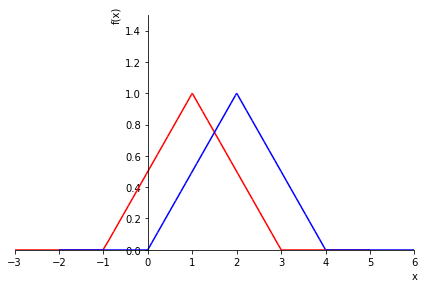

In [7]:
from module.trapezoid_fuzzy_number import TrapezoidFuzzyNumber
from sympy import symbols
x = symbols('x')
A = TrapezoidFuzzyNumber((-1 , 3), (x+1)/2, (3-x)/2)
B = TrapezoidFuzzyNumber((0 , 4), x/2, (4-x)/2)
plot_multiple([A,B])

Suppose we wish to find $A+B$.

Firstly, we find the $\alpha$-cut of $A$ and $B$.

$\frac{x+1}{2} = \alpha \Rightarrow x = 2\alpha - 1$

$\frac{3-x}{2} = \alpha \Rightarrow x = 3 - 2\alpha$

Thus, $A_\alpha = [2\alpha - 1, 3 - 2\alpha]$

$\frac{x}{2} = \alpha \Rightarrow x = 2\alpha$

$\frac{4-x}{2} = \alpha \Rightarrow x = 4 - 2\alpha$

Thus, $B_\alpha = [2\alpha, 4 - 2\alpha]$

Therefore, $(A + B)_\alpha = [2\alpha - 1 + 2\alpha, 3 - 2\alpha + 4 - 2 \alpha] = [4\alpha - 1, 7 - 4\alpha]$

Finally, since $4\alpha - 1 = x \Rightarrow \alpha = \frac{x+1}{4}$

and

$7 - 4\alpha = x \Rightarrow \alpha = \frac{7-x}{4}$

We get 

$$
(A+B)(x)\begin{cases}
0, x \leq -1 \text{ and }x \geq 7\\
\frac{x+1}{4}, -1 < x \leq 3\\
\frac{7-x}{4}, 3 < x \leq 7
\end{cases}
$$

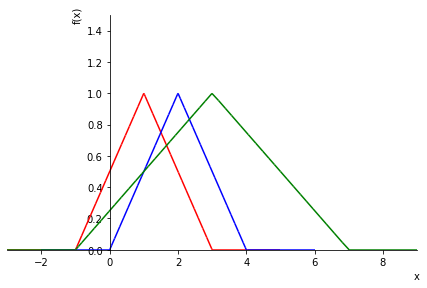

Piecewise((0, (x <= -1) | (x > 7)), (x/4 + 1/4, x <= 3), (7/4 - x/4, True))

In [8]:
plot_multiple([A,B, A+B]);
(A+B).formula

Below is the implementation of the TrapezoidFuzzyNumber.
Note that we did not implement multiplication or division, because the resulting fuzzy number may not be trapezoidal.

In [9]:
from module.trapezoid_fuzzy_number import TrapezoidFuzzyNumber
from module.alpha_cut import AlphaCut
show_implementation(AlphaCut)
show_implementation(TrapezoidFuzzyNumber, 'Section 1')

class AlphaCut:

    def __init__(self, left_bound, right_bound):
        self.left_bound = left_bound
        self.right_bound = right_bound

    def __add__(self, other):
        return AlphaCut(self.left_bound + other.left_bound, self.right_bound + other.right_bound)

    def __sub__(self, other):
        return AlphaCut(self.left_bound - other.right_bound, self.right_bound - other.left_bound)
    
    def to_fuzzy(self):
        from .trapezoid_fuzzy_number import TrapezoidFuzzyNumber
        domain = self.left_bound.subs(a, 0), self.right_bound.subs(a, 0)
        left_func = solve(self.left_bound - x, a)[0]
        right_func = solve(self.right_bound - x, a)[0]
        l, r = domain
        return TrapezoidFuzzyNumber((l, r), left_func, right_func)
class TrapezoidFuzzyNumber:

    """Section 1: """
    def __init__(self, domain, left_func, right_func):
        l, r = domain
        
        core_l, core_r = solve(left_func - 1, x), solve(right_func - 1, x)
        
        assert 